# Transfer entropy in toy systems

For this analysis I will be using the equivalence between transfer entropy and conditional mutual information

$$
T_{X\rightarrow Y} = I(Y;X^-|Y^-)
$$

and 

$$
T_{X\rightarrow Y|Z} = I(Y;X^-|Y^-,Z^-)
$$

and then the conditional mutual information is estimated via the nearest neighbor approximation of [Vlachos & Kugiumtzis, 2010](https://arxiv.org/abs/1007.0394)

$$
\hat{I}(Y;X|Z) = \psi(k) - \langle \psi(n_{xz}(i)) + \psi(n_{yz}(i)) - \psi(n_z(i)) \rangle
$$

where $\psi$ is the digamma function, $k$ is the number of neighbors to consider, $\langle \cdot \rangle$ denotes the mean. Then, if $\epsilon$ denotes the distance to the $k^{th}$ nearest neighbor, $n_i$ is the number of neighbors within that radius for a subset of the data projected into the $i$ subspace.

In [2]:
%pylab inline
import pandas as pd
import hyeenna as hy
import networkx as nx
import matplotlib as mpl
from jupyterthemes import jtplot
from matplotlib import patches
from scipy.special import psi
from scipy.integrate import ode
from scipy.integrate import odeint
from sklearn.neighbors import NearestNeighbors
jtplot.style(jtplot.infer_theme(), fscale=1.3)

Populating the interactive namespace from numpy and matplotlib


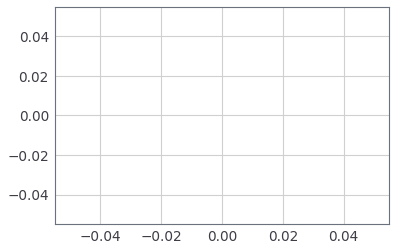

In [5]:
plt.plot([0])
jtplot.figsize(x=16, y=8)

## Stationary Autoregressive System (Acyclic)

First we define our system with the equations


$$
X_t = 3.4 X_{t-1}(1-X_{t-1})^2 e^{-X_{t-1}^2} + 0.4 \epsilon_{1,t}
$$
$$
Y_t = 3.4 Y_{t-1} (1-Y_{t-1})^2 e^{-Y_{t-1}^2} + 0.5 X_{t-5}^2 + 0.4 \epsilon_{2,t}
$$
$$
Z_t = 3.4 Z_{t-1} (1-Z_{t-1})^2 e^{-Z_{t-1}^2} + 0.8 Y_{t-5} + 0.3 X_{t-5} Z_{t-1} + 0.4 \epsilon_{3,t}
$$


where $\epsilon_i$ is a random Gaussian noise term. This process has a graphical structure seen below. All inter-variable lags are 5 timesteps. Note the pathway from $X\rightarrow Y \rightarrow Z$, as well as the nonlinear $X-Z$ term in the $Z$ equation.

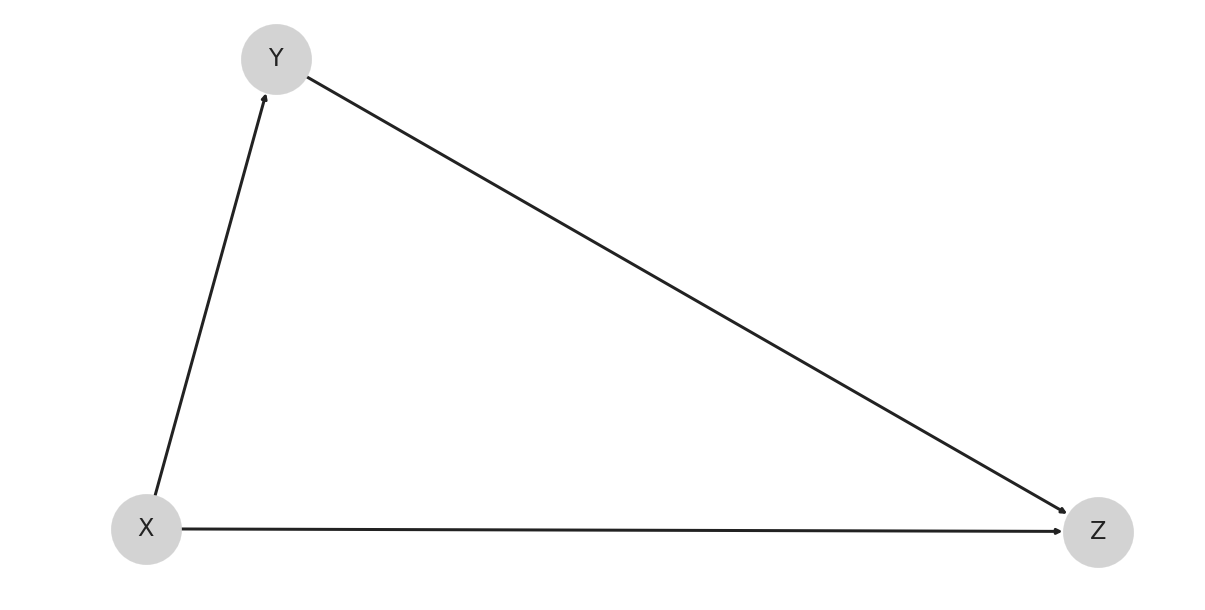

In [3]:
lags  = np.array([[1, 0, 0],
                  [10, 1, 0],
                  [5, 15, 1]]).T
graph = nx.from_numpy_matrix(lags, create_using=nx.DiGraph())
nx.draw_spring(graph, labels={0: 'X', 1: 'Y', 2: 'Z'}, node_size=5000,
        width=3, font_size=24, node_color='lightgrey')
graph

### Simulation and Unconditioned Transfer Entropy

We then simulate the system over 100000 timesteps with initial condition $(X_0, Y_0, Z_0) = (0,0,0)$ and discard the first 1000 timesteps to reduce initialization behavior. 


In [56]:
t = np.arange(0, 100000, 1)
x = np.zeros(shape=t.shape)
y = np.zeros(shape=t.shape)
z = np.zeros(shape=t.shape)
e1, e2, e3 = np.random.multivariate_normal([0, 0, 0], cov=np.eye(3), size=len(t)).T
for tt in t[30:]:
    x[tt] = (3.4 * x[tt-1] * ((1-x[tt-1])**2) * np.exp(-x[tt-1]**2)
             + 0.4 * e1[tt])
    y[tt] = (3.4 * y[tt-1] * (1-y[tt-1])**2 * np.exp(-y[tt-1]**2)
             + 0.5 * x[tt-5]**2
             + 0.4 * e2[tt])
    z[tt] = (3.4 * z[tt-1] * (1-z[tt-1])**2 * np.exp(-z[tt-1]**2)
             + 0.8 * y[tt-5] + 0.3 * x[tt-5] * z[tt-1]
             + 0.4 * e3[tt])
    
x = x[::-1][0:-1000]
y = y[::-1][0:-1000]
z = z[::-1][0:-1000]

### Unconditioned Transfer Entropy
From this we calculate the transfer entropies $T_{X\rightarrow Z}$, $T_{Y\rightarrow Z}$, and $T_{X\rightarrow Y}$.
We calculate all quantities using sample sizes of $3000$ and repeat each estimation $10$ times for a range of lags $\tau \in [1,15]$.
From the figures shown below we can see that the transfer entropy is able to pick out all connections, including the propagated effect of $X$ on $Z$ through it's mediator $Y$, shown as the spike at $\tau = 10$ in the $T_{X\rightarrow Z}$ plot. Also note that the strengths of the connections is in the correct in magnitudes.  For example the peak of $T_{Y\rightarrow Z} \approx 0.85$ and $T_{X\rightarrow Z} \approx 0.3$, while the true coupling values are $0.8$ and $0.3$, respectively.


Text(0,0.5,'$TE_{X\\rightarrow Z}$')

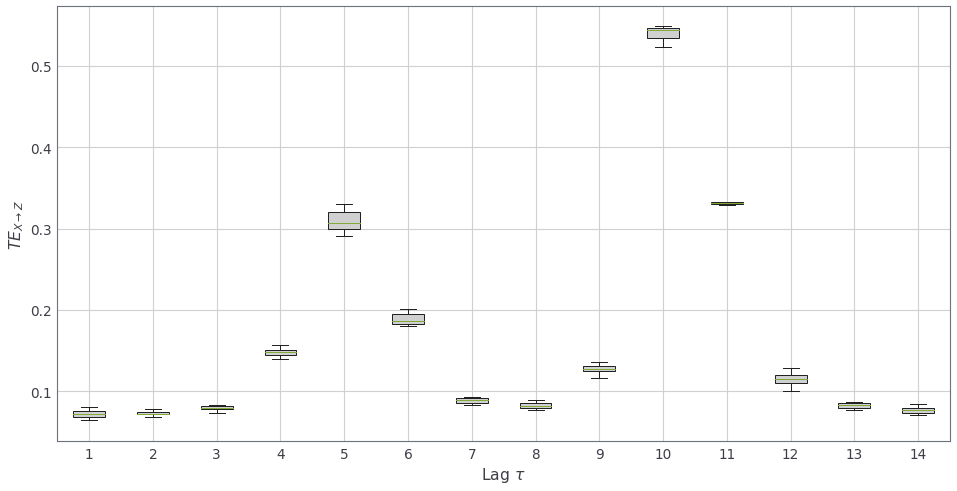

In [57]:
nrun = 10
ss = 3000
taus = np.arange(1, 15, 1)
st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': x, 'Y': z},
                         params={'tau': t, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{X\rightarrow Z}$')

Text(0,0.5,'$TE_{Y\\rightarrow Z}$')

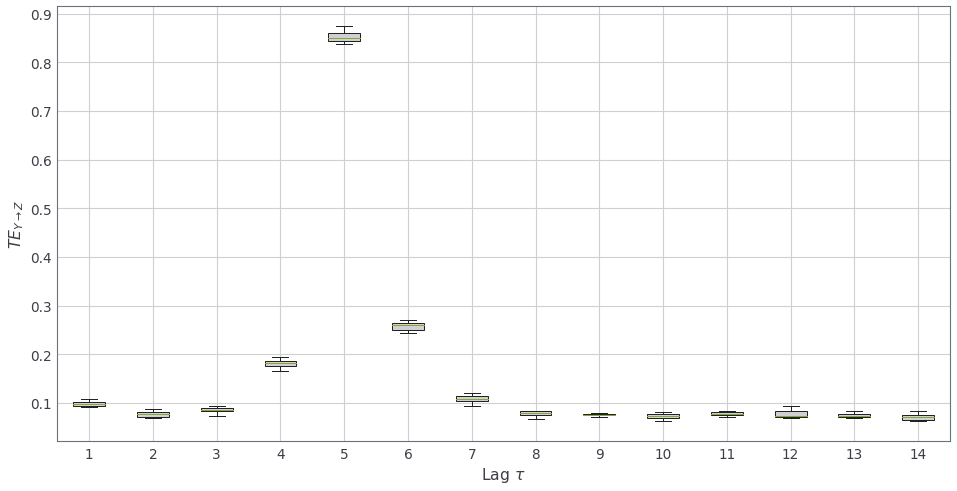

In [58]:
st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': y, 'Y': z},
                         params={'tau': t, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{Y\rightarrow Z}$')

Text(0,0.5,'$TE_{X\\rightarrow Y}$')

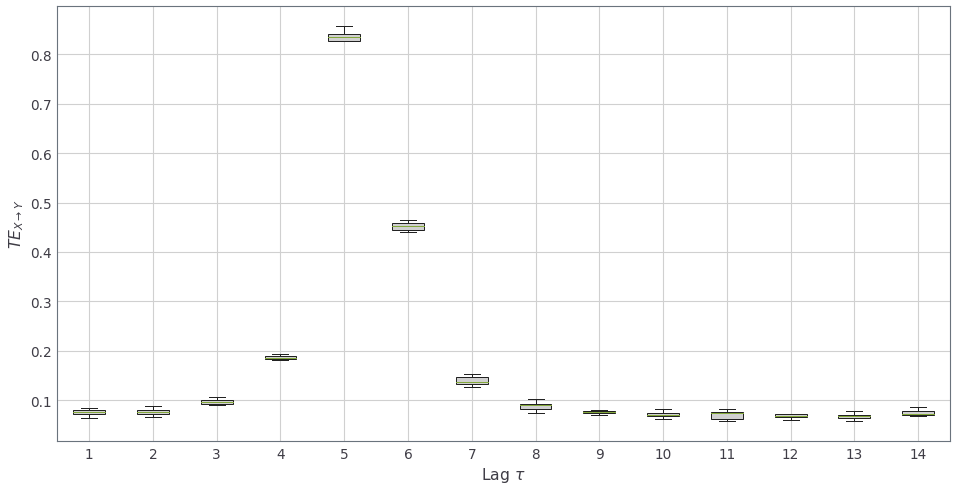

In [59]:
st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': x, 'Y': y},
                         params={'tau': t, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{X\rightarrow Y}$')

### Conditional transfer entropy

Now, we calculate $T_{X\rightarrow Z|Y}$ with the conditioning time lag of $\nu=5$. Recall this is the true lag parameter of the system.  From this calculation we can see that the information flow mediated by $Y$ is no longer detected.  This shows that the conditioning works, and we are able to fully recover the network structure of the system.

However, the main motivation for developing these methods is to be able to infer this structure without having apriori knowledge of the time lags. So, suppose we just guessed that $\nu=4$, which is close to the true value. From the second plot below we see that this misses the connection.

As a final experiment, perhaps we could instead condition over a range of $Y$ lags.  To do this, we set parameters $\nu=4$ and $m=3$.  This will effectively calculate $T_{X\rightarrow Z | Y_{t-4} Y_{t-5} Y_{t-6}}$, which should eliminate the mediated information flow. However, this merely accentuates it.

Text(0,0.5,'$TE_{X_t \\rightarrow Z_{t-\\tau}|Y_{t-12}}$')

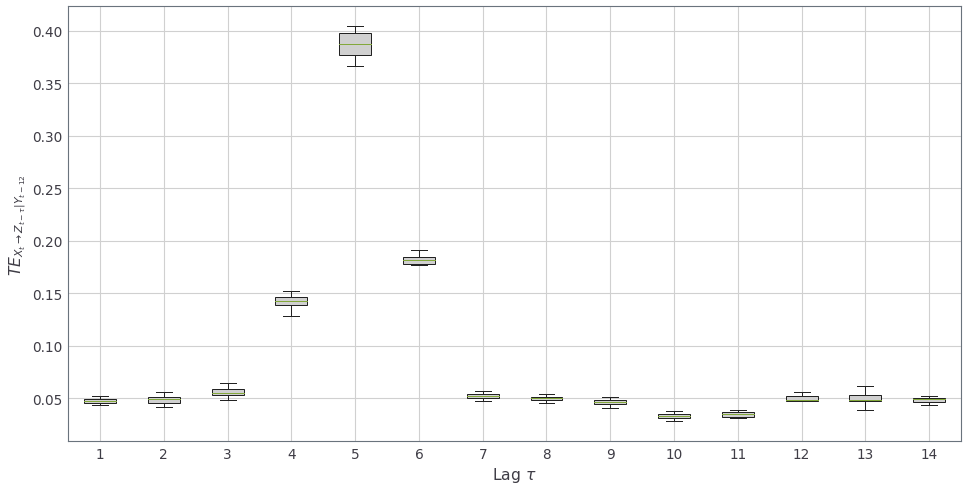

In [60]:
st2 = [hy.estimator_stats(hy.conditional_transfer_entropy,
                         data={'X': x, 'Y': z, 'Z': y.reshape(-1, 1)},
                         params={'tau': t, 'omega': 1, 'nu': 5, 
                                 'k': 1, 'l': 1, 'm': 1},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st2], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{X_t \rightarrow Z_{t-\tau}|Y_{t-12}}$')

Text(0,0.5,'$TE_{X_t \\rightarrow Z_{t-\\tau}|Y_{t-12}}$')

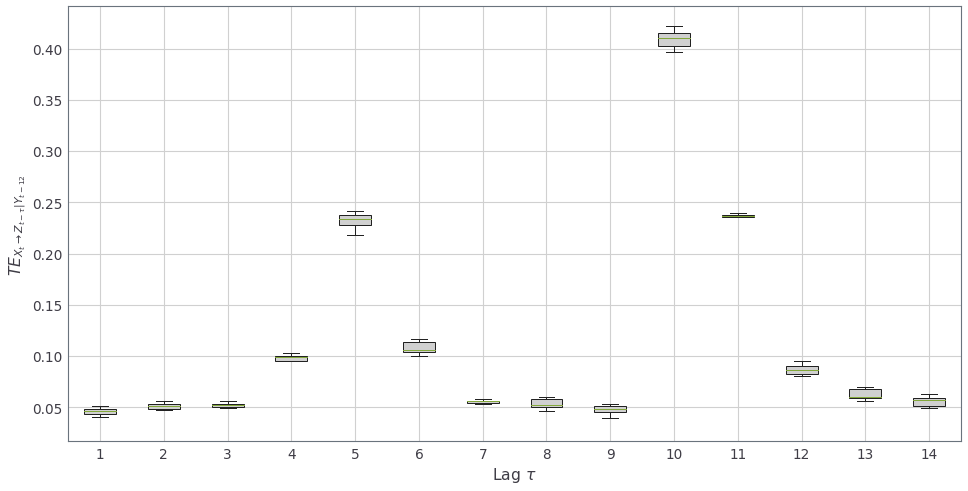

In [61]:
st2 = [hy.estimator_stats(hy.conditional_transfer_entropy,
                         data={'X': x, 'Y': z, 'Z': y.reshape(-1, 1)},
                         params={'tau': t, 'omega': 1, 'nu': 4, 
                                 'k': 1, 'l': 1, 'm': 1},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st2], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{X_t \rightarrow Z_{t-\tau}|Y_{t-12}}$')

Text(0,0.5,'$TE_{X_t \\rightarrow Z_{t-\\tau}|Y_{t-12}}$')

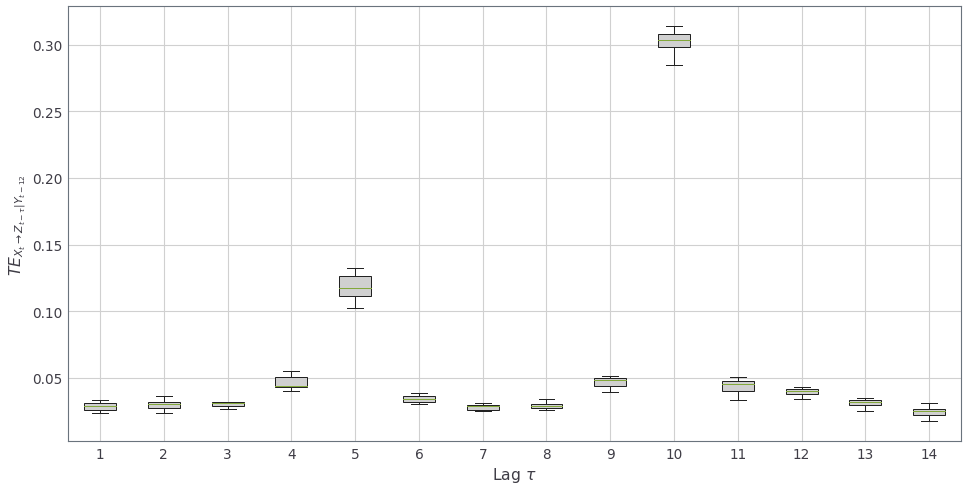

In [62]:
st2 = [hy.estimator_stats(hy.conditional_transfer_entropy,
                         data={'X': x, 'Y': z, 'Z': y.reshape(-1, 1)},
                         params={'tau': t, 'omega': 1, 'nu': 4, 
                                 'k': 1, 'l': 1, 'm': 3},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st2], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{X_t \rightarrow Z_{t-\tau}|Y_{t-12}}$')

### Multiple lag connections

Given the last test, we also might wonder if we generate a process that actually does have the range of lags from $X\rightarrow Y$ at times $t-4, t-5, \text{and} t-6$ can we use the windowed transfer entropy to condition this out?

First, I show the unconditioned transfer entropy $T_{X\rightarrow Z}$ to get a baseline of how the profile looks. There is a clearly broader peak from $\tau = 9$ to $\tau = 11$ that can be seen from the mediated effect of $Y$.

Then, I calculate the transfer entropy with a window on conditioning of $\nu \in [4,6]$. In doing so, we see a decrease in the mediated signal from $Y$, but it is still roughly the same order of magnitude as the direct effect from $X$. 

This brings us to the central problem I have been having. If transfer entropy is going to be a useful tool in hydrology we are going to need to be able to isolate relations via conditioning. However, conditioning only seems to work on single timescales, which we are unlikely to know. Further, it's unlikely that in hydrology there will be discrete time effects (except within models at their simulated timestep).

I see two reasons for this problem.

1. The most obvious (and likely), implementation error. I would be most happy if this was the case but I have not been able to find any issue in my calculation of conditional transfer entropy. Perhaps this could be a misunderstanding of how to apply the estimator for conditional mutual information.

2. This formulation of conditional transfer entropy is incorrect.  I have seen very few treatments of conditional transfer entropy with high dimensional inputs, which makes this difficult to judge.  Jakob Runge has [a paper](https://www.pik-potsdam.de/members/kurths/publikationen/2012/rungeprl108.pdf) that appears to provide an algorithm for computing high dimensional transfer entropies, perhaps this could be used to extend to the conditioned version.

In [14]:
t = np.arange(0, 100000, 1)
x = np.zeros(shape=t.shape)
y = np.zeros(shape=t.shape)
z = np.zeros(shape=t.shape)
e1, e2, e3 = np.random.multivariate_normal([0, 0, 0], cov=np.eye(3), size=len(t)).T
for tt in t[30:]:
    x[tt] = (3.4 * x[tt-1] * ((1-x[tt-1])**2) * np.exp(-x[tt-1]**2)
             + 0.4 * e1[tt])
    y[tt] = (3.4 * y[tt-1] * (1-y[tt-1])**2 * np.exp(-y[tt-1]**2)
             + 0.15 * x[tt-4]**2
             + 0.15 * x[tt-5]**2
             + 0.15 * x[tt-6]**2
             + 0.4 * e2[tt])
    z[tt] = (3.4 * z[tt-1] * (1-z[tt-1])**2 * np.exp(-z[tt-1]**2)
             + 0.8 * y[tt-5] + 0.3 * x[tt-5] * z[tt-1]
             + 0.4 * e3[tt])
    
x = x[::-1][0:-1000]
y = y[::-1][0:-1000]
z = z[::-1][0:-1000]

Text(0,0.5,'$TE_{X_t \\rightarrow Z_{t-\\tau}|Y_{t-12}}$')

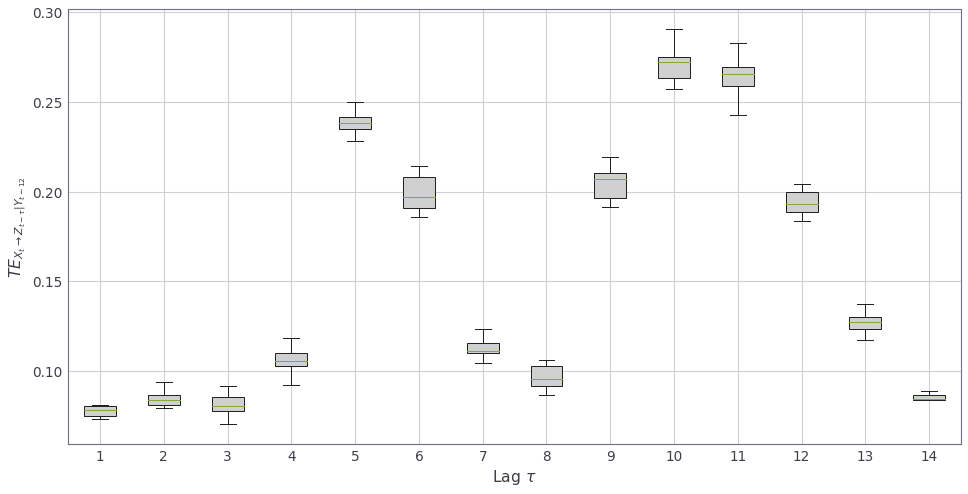

In [19]:
st2 = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': x, 'Y': z},
                         params={'tau': t, 'omega': 1, 'nu': 4, 
                                 'k': 1, 'l': 1, 'm': 3},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st2], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{X_t \rightarrow Z_{t-\tau}|Y_{t-12}}$')

Text(0,0.5,'$TE_{X_t \\rightarrow Z_{t-\\tau}|Y_{t-12}}$')

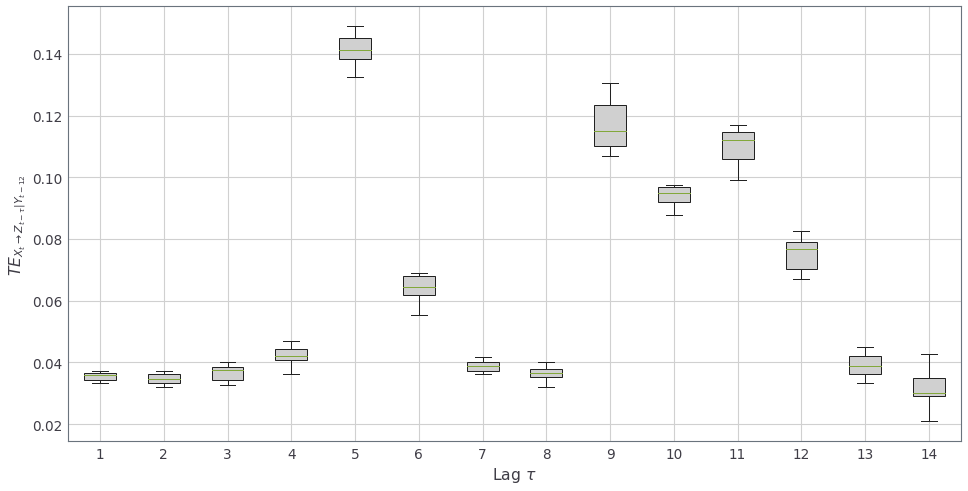

In [21]:
st2 = [hy.estimator_stats(hy.conditional_transfer_entropy,
                         data={'X': x, 'Y': z, 'Z': y.reshape(-1, 1)},
                         params={'tau': t, 'omega': 1, 'nu': 4, 
                                 'k': 1, 'l': 1, 'm': 3},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st2], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{X_t \rightarrow Z_{t-\tau}|Y_{t-12}}$')

# Other systems - only explore for your own curiousity
---

## Stationary Autoregressive Process (Cyclic)

In [3]:
t = np.arange(0, 100000, 1)
x = np.zeros(shape=t.shape)
y = np.zeros(shape=t.shape)
z = np.zeros(shape=t.shape)
e1, e2, e3 = np.random.multivariate_normal([0, 0, 0], cov=np.eye(3), size=len(t)).T
for tt in t[30:]:
    x[tt] = (3.4 * x[tt-1] * ((1-x[tt-1])**2) * np.exp(-x[tt-1]**2)
             + 0.2 * z[tt-7]
             + 0.4 * e1[tt])
    y[tt] = (3.4 * y[tt-1] * (1-y[tt-1])**2 * np.exp(-y[tt-1]**2)
             + 0.5 * x[tt-5]**2
             + 0.4 * e2[tt])
    z[tt] = (3.4 * z[tt-1] * (1-z[tt-1])**2 * np.exp(-z[tt-1]**2)
             + 0.8 * y[tt-5] + 0.3 * x[tt-5] * z[tt-1]
             + 0.4 * e3[tt])
    
x = x[::-1][0:-1000]
y = y[::-1][0:-1000]
z = z[::-1][0:-1000]

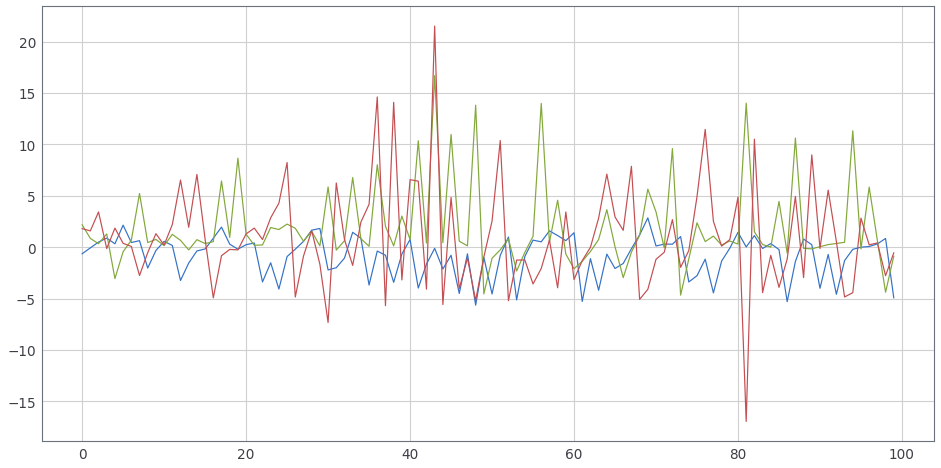

In [7]:
plt.plot(x[1000:1100])
plt.plot(y[1000:1100])
plt.plot(z[1000:1100])

Text(0,0.5,'$TE_{X\\rightarrow Z}$')

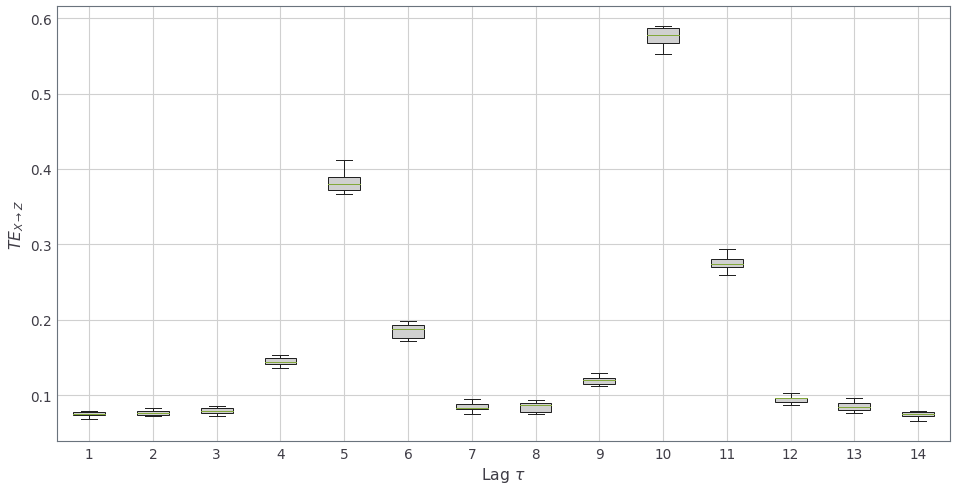

In [8]:
nrun = 10
ss = 3000
taus = np.arange(1, 15, 1)
st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': x, 'Y': z},
                         params={'tau': t, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{X\rightarrow Z}$')

Text(0,0.5,'$TE_{Y\\rightarrow Z}$')

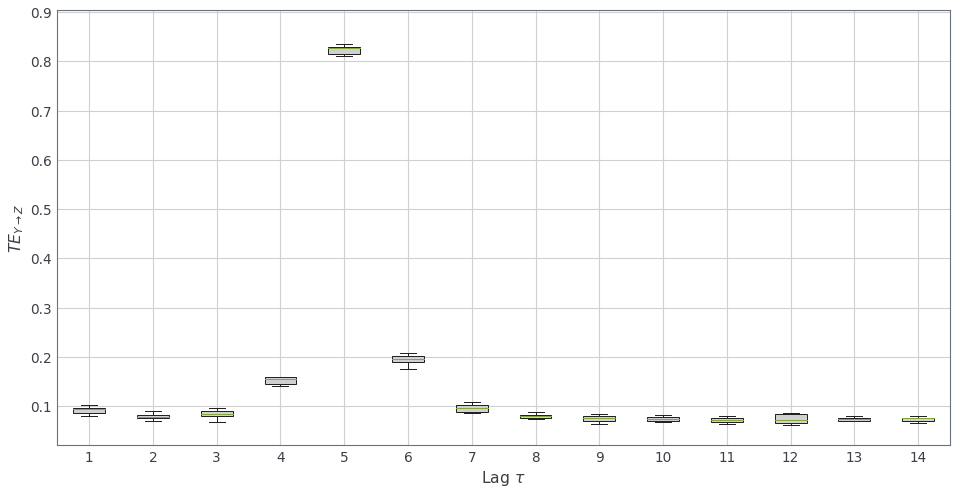

In [10]:
st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': y, 'Y': z},
                         params={'tau': t, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{Y\rightarrow Z}$')

Text(0,0.5,'$TE_{Z\\rightarrow X}$')

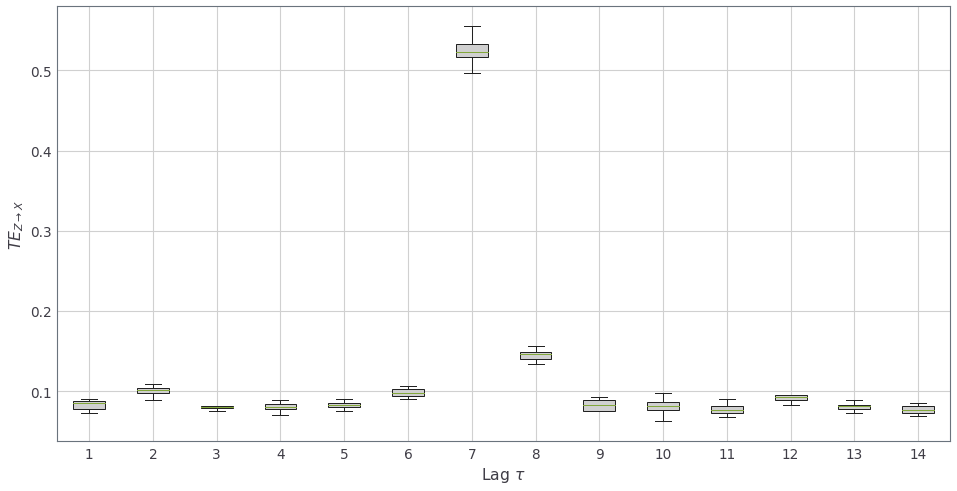

In [11]:
st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': z, 'Y': x},
                         params={'tau': t, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{Z\rightarrow X}$')

Text(0,0.5,'$TE_{Z\\rightarrow Y}$')

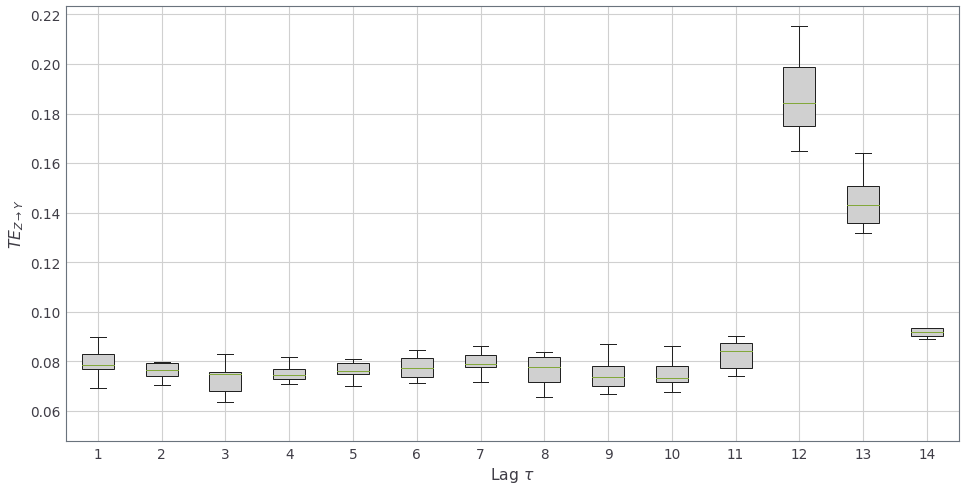

In [12]:
st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': z, 'Y': y},
                         params={'tau': t, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{Z\rightarrow Y}$')

Text(0,0.5,'$TE_{Y\\rightarrow X}$')

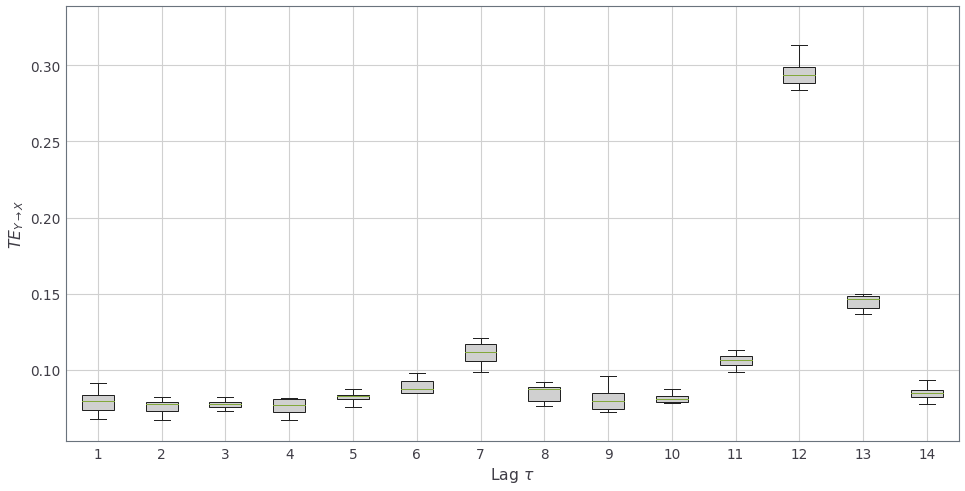

In [13]:
st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': y, 'Y': x},
                         params={'tau': t, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{Y\rightarrow X}$')

## Coupled lattice map

We will construct a coupled lattice map system which has a clearly defined spatial
coupling for us to test the capability of transfer entropy to detect said coupling.
Generally, we can write the update equation for a sytem of coupled maps as

$$
x^m_t = f\left(\epsilon^{m} x^{m-1}_{t-1} + (1-\epsilon^{m}) x^m_{t-1}\right)
$$

where $m$ is the identifier of the map and $\epsilon^{m}$ is the coupling strength for
the $m^{th}$ map. The form of the function $f$ will determine the nature of the dynamics
of the system.

### Tent map
We will first explore the tent map, which has a functional form of

$$
f(x) = \begin{cases}
         2x, & \text{if } x<0.5 \\
         2(1-x), & \text{else}
       \end{cases}
$$


In [3]:
def simple_lattice(t, xx, eps, f):
    x = xx.copy()
    for tt in t[1:]:
        x[0, tt] = f(eps[0]*x[1, tt-1] + (1-eps[0])*x[0, tt-1])
        x[1, tt] = f(eps[1]*x[0, tt-1] + (1-eps[1])*x[1, tt-1])
    return x

def full_lattice(t, xx, eps, f):
    x = xx.copy()
    n, tmax = x.shape
    for tt in t[1:]:
        for m in range(n):
            x[m, tt] = f(eps[m]*x[(m-1)%n, tt-1] + (1-eps[m])*x[m, tt-1])
    return x

def map_over_coupling(map_fun, eps_list, xx, t, f):
    x_list = []
    for eps in eps_list:
        x_list.append(map_fun(xx=xx, t=t, f=f, eps=eps))
    return x_list

In [4]:
def tent(x):
    if x < 0.5:
        return 2*x 
    else:
        return 2*(1-x)


The simplest system to simulate is a two map system with coupling that varies in only one direction.
I ran this case with one directional coupling ($\epsilon^{0} = 0.1$) and varied the value
of $\epsilon^{1}$ between $0.05$ and $0.4$. The simulations were conducted for 100000 timesteps.
For each of these simulations the transfer entropy between both maps was estimated 10 times using samples of length 5000.

Note: Going to higher values of $\epsilon$ causes the system to become fully synchronized, which will result in no transfer of information. This is expected, as the system has reached a sort of equilibrium. Simple experiments suggest that synchronization happens when $\epsilon^0 + \epsilon^1 \geq 0.5$


/pool0/data/andrbenn/.conda/all/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


(-1, 49)

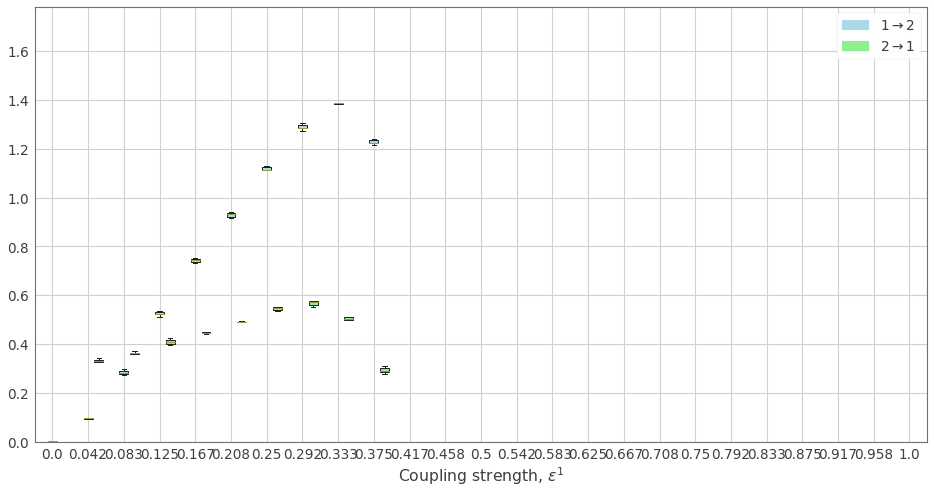

In [36]:
n = 2
t = np.arange(0, 10000, 1)
x = np.zeros(shape=(n,len(t)))
N = 25
eps_list = np.vstack([0.1+np.zeros(N), np.around(np.linspace(0.0, 1.0, N), 3)]).T
x[:, 0] = np.random.random(size=n)
x_list = map_over_coupling(simple_lattice, eps_list, xx=x, t=t, f=tent)

nrun = 10
ss = 5000
x_idx = np.arange(0, len(x_list))
st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': x[0], 'Y': x[1]},
                         params={'tau': 1, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for x in x_list]
bp1 = plt.boxplot([s['results'] for s in st], positions=(2*x_idx), patch_artist=True)

st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': x[1], 'Y': x[0]},
                         params={'tau': 1, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for x in x_list]
bp2 = plt.boxplot([s['results'] for s in st], positions=(2*x_idx)+0.6, patch_artist=True)

colors = ['lightblue', 'lightgreen']
for bplot, col in zip([bp1, bp2], colors):
    for patch in bplot['boxes']:
        patch.set_facecolor(col)

plt.xticks(2*x_idx, eps_list[:, 1])
plt.xlabel(r'Coupling strength, $\epsilon^{1}$')
patch = [patches.Rectangle([1,1], 60, 30, edgecolor='black', color=colors[0]),
         patches.Rectangle([1,1], 60, 30, edgecolor='black', color=colors[1])]
legend = plt.gca().legend(patch, [r'$1\rightarrow 2$', r'$2 \rightarrow 1$'], title='')
plt.gca().add_artist(legend)
plt.gca().set_ylim(bottom=0)
plt.xlim(2*x_idx[0]-1, 2*x_idx[-1]+1)

/pool0/data/andrbenn/.conda/all/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


(-1, 49)

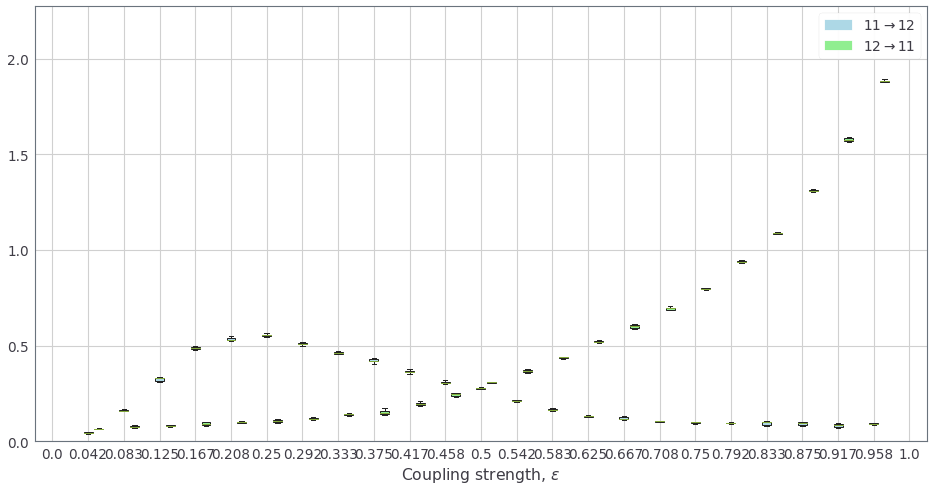

In [34]:
n = 100
t = np.arange(0, 10000, 1)
x = np.zeros(shape=(n,len(t)))
N = 25
eps_list = np.array(n*[np.around(np.linspace(0.0, 1.0, N), 3)]).T
x[:, 0] = np.random.random(size=n)

x_list = map_over_coupling(full_lattice, eps_list, xx=x, t=t, f=tent)

m = np.random.randint(n-1)
nrun = 10
ss = 3000
x_idx = np.arange(0, len(x_list))
st1 = [hy.estimator_stats(hy.transfer_entropy,
                          data={'X': x[m], 'Y': x[m+1]},
                          params={'tau': 1, 'omega': 1, 'k': 1, 'l': 1},
                          nruns=nrun, sample_size=ss) for x in x_list]
bp1 = plt.boxplot([s['results'] for s in st1], positions=(2*x_idx), patch_artist=True)

st2 = [hy.estimator_stats(hy.transfer_entropy,
                          data={'X': x[m+1], 'Y': x[m]},
                          params={'tau': 1, 'omega': 1, 'k': 1, 'l': 1},
                          nruns=nrun, sample_size=ss) for x in x_list]
bp2 = plt.boxplot([s['results'] for s in st2], positions=(2*x_idx)+0.6, patch_artist=True)

colors = ['lightblue', 'lightgreen']
for bplot, col in zip([bp1, bp2], colors):
    for patch in bplot['boxes']:
        patch.set_facecolor(col)

plt.xticks(2*x_idx, eps_list[:, 1])
plt.xlabel(r'Coupling strength, $\epsilon$')
patch = [patches.Rectangle([1,1], 60, 30, edgecolor='black', color=colors[0]),
         patches.Rectangle([1,1], 60, 30, edgecolor='black', color=colors[1])]
legend = plt.gca().legend(patch, [r'${} \rightarrow {}$'.format(m, m+1), r'${} \rightarrow {}$'.format(m+1, m)], title='')
plt.gca().add_artist(legend)
plt.gca().set_ylim(bottom=0)
plt.xlim(2*x_idx[0]-1, 2*x_idx[-1]+1)

/pool0/data/andrbenn/.conda/all/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


(-1, 49)

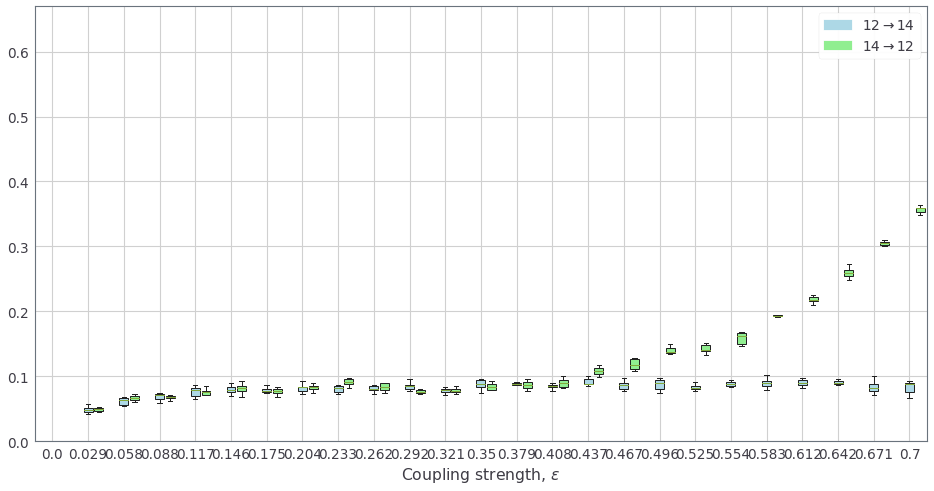

In [44]:
n = 100
t = np.arange(0, 10000, 1)
x = np.zeros(shape=(n,len(t)))
N = 25
eps_list = np.array(n*[np.around(np.linspace(0.0, 0.7, N), 3)]).T
x[:, 0] = np.random.random(size=n)

x_list = map_over_coupling(full_lattice, eps_list, xx=x, t=t, f=tent)

m = np.random.randint(n-1)
mm = m+2#np.random.randint(n-1)
nrun = 10
ss = 3000
x_idx = np.arange(0, len(x_list))
st1 = [hy.estimator_stats(hy.transfer_entropy,
                          data={'X': x[m], 'Y': x[mm]},
                          params={'tau': 2, 'omega': 1, 'k': 1, 'l': 1},
                          nruns=nrun, sample_size=ss) for x in x_list]
bp1 = plt.boxplot([s['results'] for s in st1], positions=(2*x_idx), patch_artist=True)

st2 = [hy.estimator_stats(hy.transfer_entropy,
                          data={'X': x[mm], 'Y': x[m]},
                          params={'tau': 2, 'omega': 1, 'k': 1, 'l': 1},
                          nruns=nrun, sample_size=ss) for x in x_list]
bp2 = plt.boxplot([s['results'] for s in st2], positions=(2*x_idx)+0.6, patch_artist=True)

colors = ['lightblue', 'lightgreen']
for bplot, col in zip([bp1, bp2], colors):
    for patch in bplot['boxes']:
        patch.set_facecolor(col)

plt.xticks(2*x_idx, eps_list[:, 1])
plt.xlabel(r'Coupling strength, $\epsilon$')
patch = [patches.Rectangle([1,1], 60, 30, edgecolor='black', color=colors[0]),
         patches.Rectangle([1,1], 60, 30, edgecolor='black', color=colors[1])]
legend = plt.gca().legend(patch, [r'${} \rightarrow {}$'.format(m, mm), r'${} \rightarrow {}$'.format(mm, m)], title='')
plt.gca().add_artist(legend)
plt.gca().set_ylim(bottom=0)
plt.xlim(2*x_idx[0]-1, 2*x_idx[-1]+1)

In [ ]:
x_list

### Ulam map
We will now explore the Ulam map, which has a functional form of

$$
f(x) = 2-x^2
$$

I ran this case with one directional coupling ($\epsilon^{1} = 0.0$) and varied the value
of $\epsilon^{0}$ between $0.1$ and $0.9$. The simulations were conducted for 100000 timesteps.
For each of these simulations the transfer entropy between both maps was estimated 10 times using samples of length 5000.


In [40]:
def ulam(x):
    return 2-(x*x)

/pool0/data/andrbenn/.conda/all/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


(-1, 19)

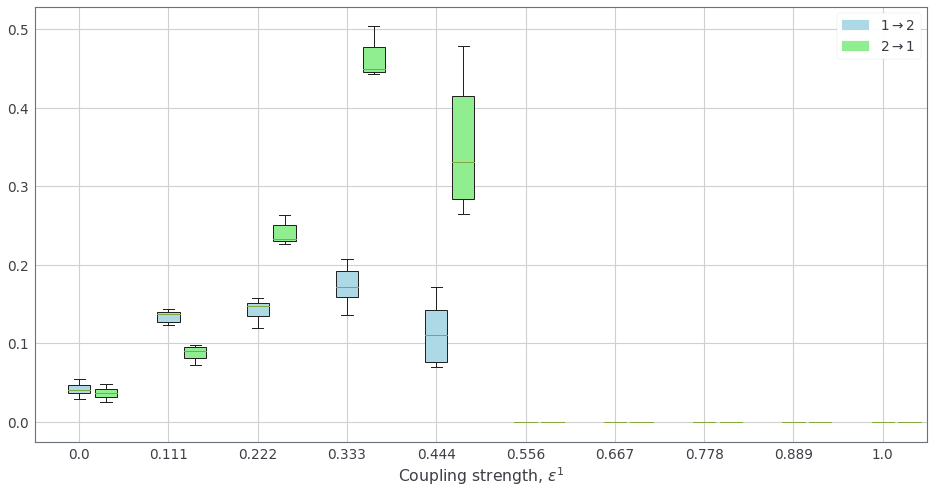

In [41]:
n = 2
t = np.arange(0, 1000, 1)
x = np.zeros(shape=(n,len(t)))
eps_list = np.vstack([np.around(np.linspace(0.0, 1, 10), 3), 0.0+np.zeros(10)]).T
x[:, 0] = np.random.random(size=n)

x_list = map_over_coupling(simple_lattice, eps_list, xx=x, t=t, f=ulam)

nrun = 10
ss = 5000
x_idx = np.arange(0, len(x_list))
st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': x[0], 'Y': x[1]},
                         params={'tau': 1, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for x in x_list]
bp1 = plt.boxplot([s['results'] for s in st], positions=(2*x_idx), patch_artist=True)

st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': x[1], 'Y': x[0]},
                         params={'tau': 1, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for x in x_list]
bp2 = plt.boxplot([s['results'] for s in st], positions=(2*x_idx)+0.6, patch_artist=True)

colors = ['lightblue', 'lightgreen']
for bplot, col in zip([bp1, bp2], colors):
    for patch in bplot['boxes']:
        patch.set_facecolor(col)

plt.xticks(2*x_idx, eps_list[:, 0])
plt.xlabel(r'Coupling strength, $\epsilon^{1}$')
patch = [patches.Rectangle([1,1], 60, 30, edgecolor='black', color=colors[0]),
         patches.Rectangle([1,1], 60, 30, edgecolor='black', color=colors[1])]
legend = plt.gca().legend(patch, [r'$1\rightarrow 2$', r'$2 \rightarrow 1$'], title='')
plt.gca().add_artist(legend)
plt.xlim(2*x_idx[0]-1, 2*x_idx[-1]+1)

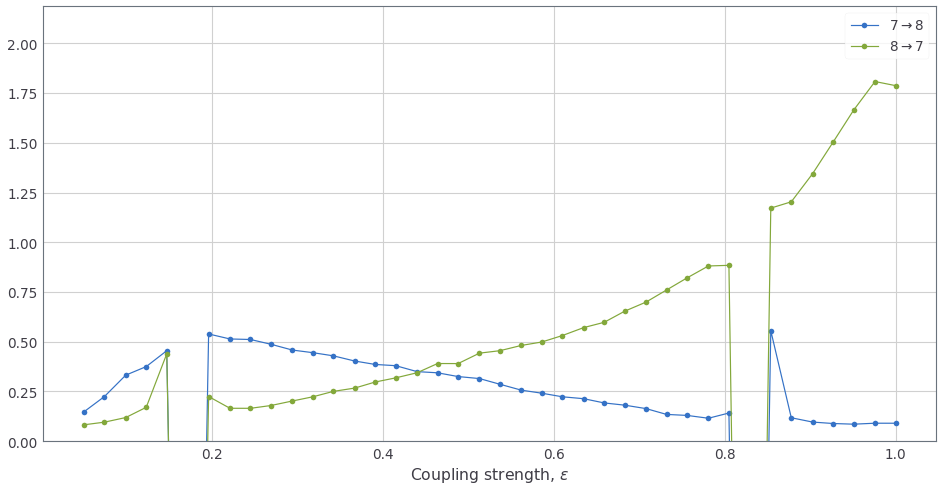

In [47]:
n = 10
t = np.arange(0, 30000, 1)
x = np.zeros(shape=(n,len(t)))
N = 40
eps_list = np.array(n*[np.around(np.linspace(0.05, 1, N), 3)]).T
x[:, 0] = np.random.random(size=n)

x_list = map_over_coupling(full_lattice, eps_list, xx=x, t=t, f=ulam)

m = np.random.randint(n-1)
nrun = 10
ss = 3000
x_idx = np.arange(0, len(x_list))
st1 = [hy.estimator_stats(hy.transfer_entropy,
                          data={'X': x[m], 'Y': x[m+1]},
                          params={'tau': 1, 'omega': 1, 'k': 1, 'l': 1},
                          nruns=nrun, sample_size=ss) for x in x_list]
bp1 = plt.plot(eps_list[:, 1], [s['median'] for s in st1], 
               label=r'${} \rightarrow {}$'.format(m, m+1), marker='o')

st2 = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': x[m+1], 'Y': x[m]},
                         params={'tau': 1, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for x in x_list]
bp2 = plt.plot(eps_list[:, 1], [s['median'] for s in st2], 
               label=r'${} \rightarrow {}$'.format(m+1, m), marker='o')

plt.xlabel(r'Coupling strength, $\epsilon$')
plt.gca().set_ylim(bottom=0)
plt.legend()

## Kuramoto Oscillator

In [ ]:
def kuramoto_rhs(theta, t, omega, n, K, A, EPS=1e-10):
    coupling = np.zeros(n)
    for j in range(n):
        for jj in range(n):
            coupling[j] += A[jj][j] * np.sin(theta[jj] - theta[j])
    return omega + (K/n) * coupling + EPS * np.random.random(size=theta.shape)

K = 1e-1
n = 3
t = np.arange(0, 10000, 1)
theta_init = 2 * np.pi * np.random.random(size=n)
omega = 1e-1 * np.random.random(size=n)
A = np.array([[0, 1, 0],
              [1, 0, 0],
              [0, 0, 0]])
x = odeint(kuramoto_rhs, theta_init, t, args=(omega, n, K, A)).T

plt.plot(np.sin(x[0][0:1000]), label='0')
plt.plot(np.sin(x[1][0:1000]), label='1')
plt.plot(np.sin(x[2][0:1000]), label='2')
plt.legend()

In [ ]:
nrun = 10
ss = 3000
taus = np.arange(0, 100, 1)
st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': x[0], 'Y': x[1]},
                         params={'tau': t, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{X\rightarrow Z}$')

In [ ]:
st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': x[0], 'Y': x[2]},
                         params={'tau': t, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{X\rightarrow Z}$')

In [ ]:
st = [hy.estimator_stats(hy.transfer_entropy,
                         data={'X': x[1], 'Y': x[2]},
                         params={'tau': t, 'omega': 1, 'k': 1, 'l': 1},
                         nruns=nrun, sample_size=ss) for t in taus]
bp1 = plt.boxplot([s['results'] for s in st], positions=taus, patch_artist=True)
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'$TE_{X\rightarrow Z}$')